Trend in the funding policies for Italian cultural institutes

In Italy, every region has different amount of funding and level of participation in cultural activities.
This project aims to discover how the public funding distributed in the last 10 years is, and how the trend of visitors changes through time.

In [1]:
import pandas as pd

project_20 = pd.read_csv("data/progetti_esteso_CULTURA_TURISMO_2014-2020_20250430.csv", sep=';', low_memory=False)
project_20 = project_20[['CUP','DATA_INIZIO_PREV_STUDIO_FATT','OC_DATA_INIZIO_PROGETTO','OC_DATA_FINE_PROGETTO_EFFETTIVA','DEN_REGIONE','DEN_PROVINCIA','DEN_COMUNE','FINANZ_TOTALE_PUBBLICO','FINANZ_STATO_ESTERO','FINANZ_PRIVATO']]
project_27 = pd.read_csv("data/progetti_esteso_CULTURA_TURISMO_2021-2027_20250430.csv", sep=';', low_memory=False)
project_27 = project_27[['CUP', 'DATA_INIZIO_PREV_STUDIO_FATT','OC_DATA_INIZIO_PROGETTO','OC_DATA_FINE_PROGETTO_EFFETTIVA','DEN_REGIONE','DEN_PROVINCIA','DEN_COMUNE','FINANZ_TOTALE_PUBBLICO','FINANZ_STATO_ESTERO','FINANZ_PRIVATO']]
all_projects = pd.concat([project_20, project_27], ignore_index=True)
all_projects = all_projects.drop_duplicates(subset=['CUP'], keep='first')

In [2]:
date_columns = ['DATA_INIZIO_PREV_STUDIO_FATT','OC_DATA_INIZIO_PROGETTO','OC_DATA_FINE_PROGETTO_EFFETTIVA']

all_projects[date_columns] = (all_projects[date_columns].apply(lambda col: pd.to_datetime(col.astype('Int64').astype(str), format='%Y%m%d', errors='coerce')))

all_projects = all_projects.sort_values(by=date_columns, ascending=[True, True, True], na_position='last').reset_index(drop=True)
all_projects.to_csv("data/open_coesione.csv", index=False, encoding="utf-8")

In [3]:
import pandas as pd
import os
import glob

def transform_table(file):
    year = os.path.basename(file).split("_")[2]
    #detect header of table
    with open(file, "r", encoding = "latin-1") as f:
        for i,line in enumerate(f):
            if line.startswith("Regione"):
                header_row = i
                break
    visitors = pd.read_csv(file, skiprows = header_row, sep=";", encoding="latin-1")
    visitors.rename(columns={"Totale complessivo":"Totale_regione"}, inplace= True) 
    # set 'Regione' as columns, months as rows
    visitors = visitors.set_index("Regione").T
    
    visitors.dropna(axis=1, how="all", inplace= True)
    visitors.dropna(axis=0, how="all", inplace= True)
    
    # rename the rows to add the year
    visitors.index = [f"{month}_{year}" for month in visitors.index]

    return visitors

In [8]:
# apply to all visitatori files
files = glob.glob("data/musei_tavola5_*_visitatori.csv")
total_visitors = []
for f in files:
    total_visitors.append(transform_table(f))
    
# merge along rows
output_visitors = pd.concat(total_visitors)
output_visitors.to_csv("data/mic_visitors.csv", encoding="utf-8")

# apply to all introiti files
tables_income = glob.glob("data/musei_tavola5_*_introiti.csv")
total_income = []
for i in tables_income:
    total_income.append(transform_table(i))
    
# merge along rows
output_income = pd.concat(total_income)
output_income.to_csv("data/mic_income.csv", encoding="utf-8")


In [ ]:
!pip install plotly

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load CSV
df = pd.read_csv("data/OpenCoesione.csv")


def parse_number(val):
    if pd.isna(val):
        return 0
    s = str(val).strip().replace("€", "").replace(" ", "")
    if "," in s and "." in s:
        s = s.replace(".", "").replace(",", ".")
    else:
        s = s.replace(",", ".")
    try:
        return float(s)
    except:
        return 0

def extract_year(date_str):
    if pd.isna(date_str):
        return None
    s = str(date_str)
    
    if len(s) >= 10 and s[4] == "-":
        return int(s[:4])
    
    if "/" in s and len(s.split("/")[-1]) == 4:
        return int(s.split("/")[-1])
    
    import re
    match = re.search(r"(19|20)\d{2}", s)
    return int(match.group(0)) if match else None


for col in ["FINANZ_TOTALE_PUBBLICO", "FINANZ_STATO_ESTERO", "FINANZ_PRIVATO"]:
    df[col] = df[col].apply(parse_number)


df["year"] = df["OC_DATA_INIZIO_PROGETTO"].apply(extract_year)


agg = df.groupby("year").agg({
    "FINANZ_TOTALE_PUBBLICO": "sum",
    "FINANZ_STATO_ESTERO": "sum",
    "FINANZ_PRIVATO": "sum"
}).reset_index()


agg["pubblico"] = agg["FINANZ_TOTALE_PUBBLICO"] / 1e6
agg["estero"]   = agg["FINANZ_STATO_ESTERO"] / 1e6
agg["privato"]  = agg["FINANZ_PRIVATO"] / 1e6

# --- Filter rules ---
agg = agg[(agg["year"] >= 1997) & (agg["year"] != 2025)]
agg = agg[(agg["pubblico"] > 0) | (agg["estero"] > 0) | (agg["privato"] > 0)]

fig = go.Figure()

fig.add_trace(go.Bar(
    x=agg["year"], y=agg["pubblico"],
    name="Pubblico", marker_color="#1976d2",
    hovertemplate="<b>%{x}</b><br>Pubblico: €%{y:.2f} M<extra></extra>"
))

fig.add_trace(go.Bar(
    x=agg["year"], y=agg["estero"],
    name="Estero", marker_color="#43a047",
    hovertemplate="<b>%{x}</b><br>Estero: €%{y:.2f} M<extra></extra>"
))

fig.add_trace(go.Bar(
    x=agg["year"], y=agg["privato"],
    name="Privato", marker_color="#ff7043",
    hovertemplate="<b>%{x}</b><br>Privato: €%{y:.2f} M<extra></extra>"
))


fig.update_layout(
    barmode="stack",
    xaxis=dict(title="Start Year", tickmode="linear", dtick=1, tickangle=-90),
    yaxis=dict(title="Funding (Million €)"),
    margin=dict(t=40, l=80, r=30, b=100),
    height=600,
    width=950
)
import plotly.io as pio
pio.renderers.default = "notebook" 

fig.show()


Heatmap on monthly funding of projects of each region in Italy

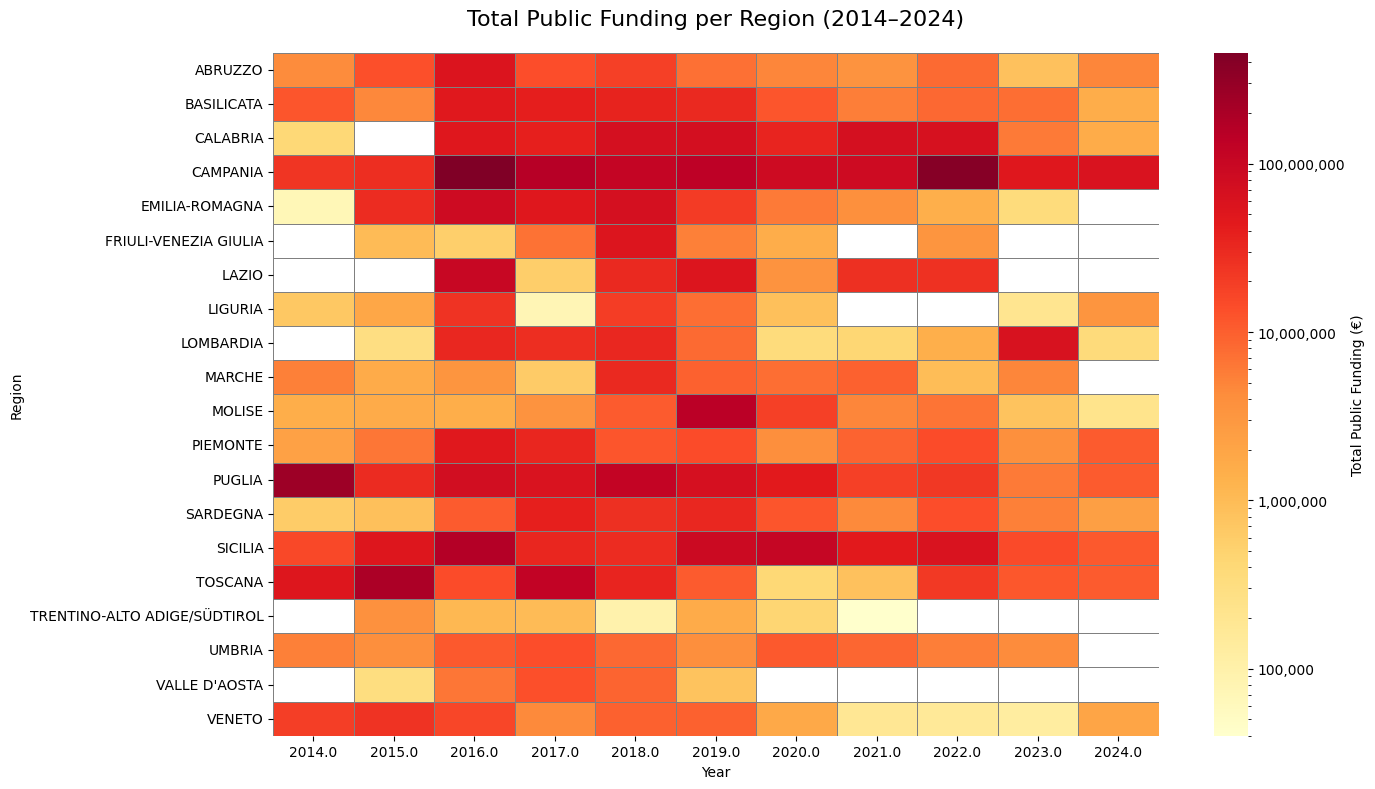

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker

# --- Load dataset ---
file_path = "data/OpenCoesione.csv"
df = pd.read_csv(file_path, dtype=str)

# Financing column
fin_col = "FINANZ_TOTALE_PUBBLICO"

# --- Convert financing to numeric ---
df[fin_col] = (
    df[fin_col].astype(str)
    .str.replace(r"[^\d,.\-]", "", regex=True)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
)
df[fin_col] = pd.to_numeric(df[fin_col], errors="coerce")

# --- Drop rows without province info ---
df = df[df['DEN_PROVINCIA'].notna() & (df['DEN_PROVINCIA'].str.strip() != "")]

# --- Handle multi-region allocation ---
df['num_regions'] = df['DEN_REGIONE'].str.split(":::").str.len()
df_expanded = df.assign(DEN_REGIONE=df['DEN_REGIONE'].str.split(":::")).explode('DEN_REGIONE')
df_expanded['DEN_REGIONE'] = df_expanded['DEN_REGIONE'].str.strip()
df_expanded[fin_col] = df_expanded[fin_col] / df_expanded['num_regions']

# --- Normalize region names ---
region_map = {
    "TRENTINO-ALTO ADIGE": "TRENTINO-ALTO ADIGE/SÜDTIROL",
    "TRENTINO ALTO ADIGE": "TRENTINO-ALTO ADIGE/SÜDTIROL",
    "VALLE D’AOSTA": "VALLE D'AOSTA",
    "FRIULI VENEZIA GIULIA": "FRIULI-VENEZIA GIULIA",
}
df_expanded['DEN_REGIONE'] = df_expanded['DEN_REGIONE'].replace(region_map)

# Drop non-regions
to_drop = ["PAESI EUROPEI", "AMBITO NAZIONALE"]
df_expanded = df_expanded[~df_expanded['DEN_REGIONE'].isin(to_drop)]

# --- Extract project start year ---
df_expanded['OC_DATA_INIZIO_PROGETTO'] = pd.to_datetime(
    df_expanded['OC_DATA_INIZIO_PROGETTO'], errors="coerce"
)
df_expanded['YEAR'] = df_expanded['OC_DATA_INIZIO_PROGETTO'].dt.year
df_expanded = df_expanded[(df_expanded['YEAR'] >= 2014) & (df_expanded['YEAR'] <= 2024)]

# --- Aggregate funding by Region × Year ---
funding_matrix = df_expanded.groupby(['DEN_REGIONE', 'YEAR'])[fin_col].sum().reset_index()
heatmap_data = funding_matrix.pivot(index='DEN_REGIONE', columns='YEAR', values=fin_col).fillna(0)

# --- Plot Heatmap with log scale and formatted legend ---
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor="gray",
    norm=LogNorm(vmin=heatmap_data[heatmap_data>0].min().min(), vmax=heatmap_data.max().max()),
    cbar_kws={
        'label': 'Total Public Funding (€)',
        'format': mticker.StrMethodFormatter('{x:,.0f}')  # show thousands separators
    }
)

plt.title("Total Public Funding per Region (2014–2024)", fontsize=16, pad=20)
plt.xlabel("Year")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import geopandas as gpd
import folium
import branca.colormap as cm
from ipywidgets import Dropdown, interact

# --- 1. Helper: normalize names ---
def normalize_region_name(name: str) -> str:
    if not isinstance(name, str):
        return ""
    normalized = "".join(ch for ch in name.lower() if ch.isalnum())
    if "trentino" in normalized:
        normalized = "trentinoaltoadige"
    if "valle" in normalized:
        normalized = "valledaosta"
    return normalized

# --- 2. Load data ---
df = pd.read_csv("data/Mic_visitors.csv", dtype=str)
gdf = gpd.read_file("data/italy_regions.geojson")

# --- 3. Reshape visitor data ---
long_df = df.melt(id_vars=["Unnamed: 0"], var_name="Region", value_name="Visitors")
long_df["Visitors"] = (
    long_df["Visitors"]
    .fillna("0")
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
    .astype(float)
)
long_df["Year"] = long_df["Unnamed: 0"].str.extract(r"(\d{4})").astype(int)
long_df["region_norm"] = long_df["Region"].apply(normalize_region_name)

yearly_data = long_df.groupby(["region_norm", "Year"])["Visitors"].sum().reset_index()

# --- 4. Normalize GeoDataFrame ---
if "name" in gdf.columns:
    name_col = "name"
elif "reg_name" in gdf.columns:
    name_col = "reg_name"
else:
    raise KeyError("Could not find a region name column.")

gdf["region_norm"] = gdf[name_col].apply(normalize_region_name)

# --- 5. Fixed color and opacity ---
fixed_color = "#3186cc"
fixed_opacity = 0.6

# --- 6. Determine circle size scaling ---
max_visitors = yearly_data["Visitors"].max()
min_radius = 3
max_radius = 20

def scale_radius(visitors):
    """Scale visitors to a circle radius between min_radius and max_radius"""
    if visitors <= 0:
        return 0
    return min_radius + (max_radius - min_radius) * (visitors / max_visitors)

# --- 7. Function to draw map for a single year ---
def draw_map(selected_year=2014):
    m = folium.Map(location=[41.87194, 12.56738], zoom_start=5.5, tiles="cartodbpositron")
    
    year_df = yearly_data[yearly_data["Year"] == selected_year].set_index("region_norm")
    
    for _, row in gdf.iterrows():
        region = row["region_norm"]
        if region not in year_df.index:
            continue
        visitors = year_df.loc[region, "Visitors"]
        if visitors == 0:
            continue
        centroid = row.geometry.centroid
        folium.CircleMarker(
            location=[centroid.y, centroid.x],
            radius=scale_radius(visitors),      # scaled size
            color=fixed_color,
            fill=True,
            fill_color=fixed_color,
            fill_opacity=fixed_opacity,
            popup=f"<b>{row[name_col]}</b><br>Year: {selected_year}<br>Visitors: {int(visitors):,}"
        ).add_to(m)
    return m

# --- 8. Dropdown widget ---
year_dropdown = Dropdown(options=list(range(2014, 2025)), value=2014, description='Year:')
interact(draw_map, selected_year=year_dropdown)


interactive(children=(Dropdown(description='Year:', options=(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

<function __main__.draw_map(selected_year=2014)>